In [1]:
import os
import sys
import torch
import numpy as np
from torch import matmul as m
from matplotlib import pyplot as plt
from sdes import SDE,ConstantDiffusion,TwoDimensionalSynDrift,DoubleWellDrift,MaxDiffusion

from torch.distributions import MultivariateNormal,Normal

sys.path.insert(0,".")

from utils import define_grid_ranges,define_mesh_points
from gps import MultivariateNormal,white_noise_kernel
from sde_gp_em import where_mc_time,jacobian_of_drift

### Run SDE

In [16]:
dt = 0.002
number_of_steps = 100
num_paths = 3
sigma = 1.

x_0 = torch.rand((1,)).unsqueeze(-1)
real_drift = DoubleWellDrift(a=4.,b=4.)
#diffusion = MaxDiffusion()
diffusion = ConstantDiffusion(sigma=sigma)

#x_0 = torch.rand((2,)).unsqueeze(0)
#real_drift = TwoDimensionalSynDrift()
#diffusion = ConstantDiffusion(sigma=sigma)

two_dimensional_sde = SDE(real_drift,diffusion,dt=dt)
dense_path_realization = two_dimensional_sde.simulate(x_0, number_of_steps, num_paths=num_paths)
dense_path_realization = dense_path_realization[0,:,:]

In [17]:
num_dense_steps_in_bridge = 20
number_of_steps = dense_path_realization.size(0)
dense_time = torch.arange(0,number_of_steps)*dt
max_time = number_of_steps*dt
observation_index = range(0,number_of_steps,num_dense_steps_in_bridge)
sparse_observation_time = dense_time[observation_index]
sparse_observations = dense_path_realization[observation_index]

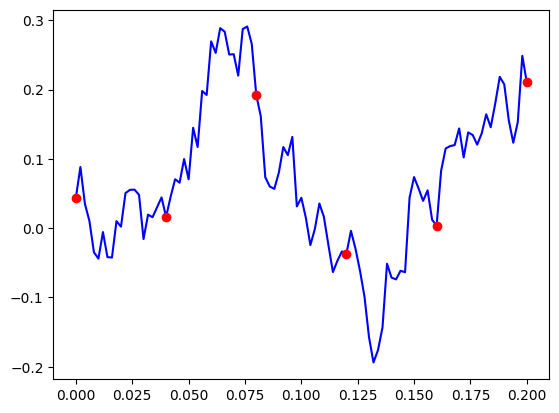

In [18]:
plt.plot(dense_time,dense_path_realization[:,0],"b-")
plt.plot(sparse_observation_time,sparse_observations[:,0],"ro")
plt.show()

In [22]:
def OU(mc_times,observation_times,observations,diffusion,drift,x_nmc=100,t_nmc=100,evidence=False):
    """
    OU Bridge functions
    """
    assert mc_times.max() < observation_times.max()
    time_nmc = mc_times.size(0)
    n_points = observations.size(0)
    dimensions = observations.size(1)

    diffusion_diagonal = diffusion(observations)
    drift_at_points = drift(observations)
    Gamma = jacobian_of_drift(drift,observations)

    D = torch.zeros((n_points,dimensions,dimensions))
    E = torch.zeros((n_points,2*dimensions,2*dimensions))
    OI = torch.zeros((2*dimensions,dimensions))
    OI[dimensions:,:] = torch.eye(dimensions)

    D[:,range(dimensions),range(dimensions)] = diffusion_diagonal
    E[:,:dimensions,:dimensions] = Gamma 
    E[:,:dimensions:,dimensions:] = D
    E[:,dimensions:,dimensions:] = Gamma.transpose(2,1)

    where_mc_time_index = where_mc_time(mc_times,observation_times)

    z_k = observations[where_mc_time_index]
    z_k1 = observations[where_mc_time_index+1]

    f_k = drift_at_points[where_mc_time_index,:]
    E_k = E[where_mc_time_index,:,:]
    Gamma_k = Gamma[where_mc_time_index,:,:]
    Gamma_k_inv = torch.inverse(Gamma_k)
    D_k = D[where_mc_time_index,:,:]

    time_difference_k1 = observation_times[where_mc_time_index+1,None,None]-mc_times[:,None,None]
    time_difference_k = mc_times[:,None,None] - observation_times[where_mc_time_index,None,None]
    time_difference_k = torch.clamp(time_difference_k,1e-3)

    E_k1 = torch.matrix_exp(E_k*time_difference_k1)
    E_k1 = torch.matmul(E_k,OI)

    E_k = torch.matrix_exp(E_k*time_difference_k)
    E_k = torch.matmul(E_k,OI)

    A_s1 = E_k1[:,:dimensions,:]
    B_s1 = E_k1[:,dimensions:,:]

    A_s = E_k[:,:dimensions,:]
    B_s = E_k[:,dimensions:,:]

    S_s1 = torch.matmul(A_s1,torch.inverse(B_s1))
    S_s1_inv = torch.inverse(S_s1)

    S_s = torch.matmul(A_s,torch.inverse(B_s))
    S_s_inv = torch.inverse(S_s)

    if f_k.size(1) == 1:
        alpha_k = z_k + m(Gamma_k_inv,f_k.unsqueeze(-1))[:,0,:]
    else:
        alpha_k = z_k + m(Gamma_k_inv,f_k.unsqueeze(-1)).squeeze()

    ME1 = torch.matrix_exp(-Gamma_k.transpose(2,1)*time_difference_k1)
    ME2 = torch.matrix_exp(-Gamma_k*time_difference_k1)

    C_t = torch.inverse(m(ME1,m(S_s1_inv,ME2))+S_s_inv)

    ME3 = m(C_t,m(ME1,S_s1_inv))
    a = z_k1[:,:,None] - alpha_k[:,:,None] + m(ME2,alpha_k[:,:,None])

    ME4 = m(C_t,S_s_inv)
    ME5 = torch.matrix_exp(-Gamma_k*time_difference_k)
    
    b = alpha_k[:,:,None] + m(ME5,(z_k[:,:,None]-alpha_k[:,:,None]))

    m_t = m(ME3,a) + m(ME4,b)
    if dimensions>1:
        q_t = MultivariateNormal(m_t.squeeze(),C_t)
        monte_carlo_points = q_t.sample((x_nmc,))
    else:
        q_t = Normal(m_t.squeeze(),C_t.squeeze())
        monte_carlo_points = q_t.sample((x_nmc,)).unsqueeze(-1)

    # AVERAGE DRIFT
    x_nmc,time_nmc,_ = monte_carlo_points.shape
    monte_carlo_points_ = monte_carlo_points.reshape(x_nmc*time_nmc,-1) # first index 
    full_mc = x_nmc*time_nmc

    Gamma_k_ = Gamma_k.repeat((x_nmc,1,1))
    S_s1_inv_ = S_s1_inv.repeat((x_nmc,1,1))
    z_k_ = z_k.repeat((x_nmc,1))
    z_k1_ = z_k1.repeat((x_nmc,1))
    alpha_k_ = alpha_k.repeat((x_nmc,1))
    f_k_ = f_k.repeat((x_nmc,1)) 
    time_difference_k1_ = time_difference_k1.repeat((x_nmc,1,1)) 
    D_k_ = D_k.repeat((x_nmc,1,1))

    A = f_k_[:,:,None] - m(Gamma_k_,(monte_carlo_points_ - z_k_)[:,:,None])
    MEa = torch.matrix_exp(-Gamma_k_.transpose(2,1)*time_difference_k1_)
    MEb = torch.matrix_exp(-Gamma_k_*time_difference_k1_)
    B = m(D_k_,m(MEa,S_s1_inv_))
    C = z_k1_[:,:,None] - alpha_k_[:,:,None] - m(MEb,(monte_carlo_points_-alpha_k_)[:,:,None])

    g_x = A + m(B,C)

    if dimensions>1:
        A_x = q_t.log_prob(monte_carlo_points).reshape(-1)
    else:
        A_x = q_t.log_prob(monte_carlo_points.squeeze()).reshape(-1)
        
    return monte_carlo_points_,m_t,C_t,A_x,g_x

In [23]:
t_nmc = 1000
#mc_times = torch.rand((t_nmc,))*max_time
mc_times = torch.linspace(0.,max_time-2*dt,100)
output =  OU(mc_times,sparse_observation_time,sparse_observations,diffusion,real_drift,x_nmc=100)
monte_carlo_points_,m_t,C_t,A_x,g_x = output

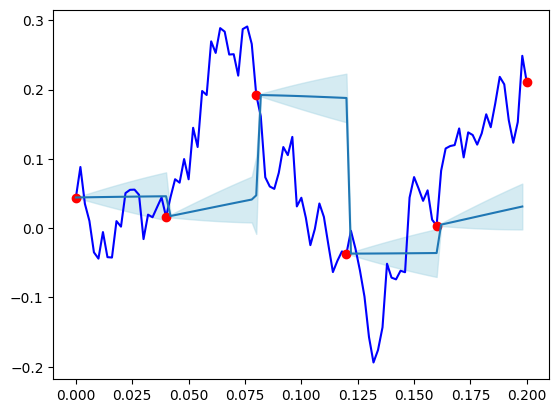

In [24]:
m_t = m_t.detach().squeeze()
C_t = C_t.squeeze().detach() 
plt.plot(dense_time,dense_path_realization[:,0],"b-")
plt.plot(sparse_observation_time,sparse_observations[:,0],"ro")
plt.fill_between(mc_times, m_t - C_t, m_t + C_t, color='lightblue', alpha=0.5, label='1 Std Dev')
plt.plot(mc_times,m_t)

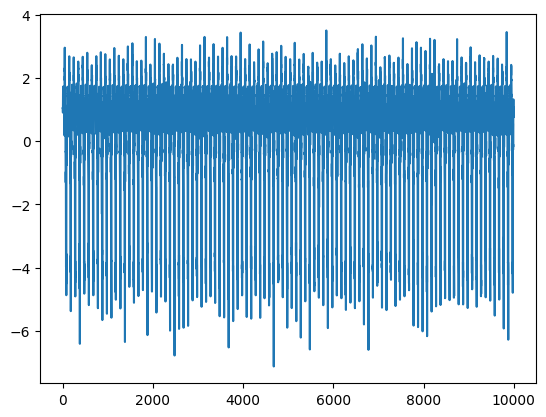

In [9]:
plt.plot(g_x.squeeze().detach().numpy())